In [10]:
import warnings, sys
if sys.warnoptions:
    warnings.simplefilter("ignore", DeprecationWarning)
!pip install -q --upgrade pip
!pip install -q gensim
!pip install -q nltk beautifulsoup4 lxml

# ========== 1.  IMPORTS ==========
import requests, bs4, re, time, pandas as pd, numpy as np
import nltk, gensim
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

nltk.download('stopwords', quiet=True)
STOP   = set(stopwords.words('english'))
STEMMER = PorterStemmer()

# ========== 2.  URL LIST ==========
URLS = [
    "https://en.wikipedia.org/wiki/Machine_learning",
    "https://en.wikipedia.org/wiki/Supervised_learning",
    "https://en.wikipedia.org/wiki/Unsupervised_learning",
    "https://en.wikipedia.org/wiki/Reinforcement_learning",
    "https://en.wikipedia.org/wiki/Deep_learning",
    "https://en.wikipedia.org/wiki/Climate_change",
    "https://en.wikipedia.org/wiki/Effects_of_climate_change",
    "https://en.wikipedia.org/wiki/Greenhouse_gas",
    "https://en.wikipedia.org/wiki/Global_warming_potential",
    "https://en.wikipedia.org/wiki/Climate_change_mitigation",
    "https://en.wikipedia.org/wiki/Renaissance_art",
    "https://en.wikipedia.org/wiki/Italian_Renaissance",
    "https://en.wikipedia.org/wiki/Leonardo_da_Vinci",
    "https://en.wikipedia.org/wiki/Michelangelo",
    "https://en.wikipedia.org/wiki/Sistine_Chapel"
]
LABELS = [u.split("/")[-1].replace("_", " ") for u in URLS]

# ========== 3.  DOWNLOAD ==========
def get_text(url):
    r = requests.get(url, headers={"User-Agent": "Colab-TopicModel/1.0"})
    r.raise_for_status()
    soup = bs4.BeautifulSoup(r.text, "lxml")
    for tag in soup(["table", "sup", "figure", "span", "script", "style"]):
        tag.decompose()
    return " ".join(p.get_text(" ", strip=True)
                    for p in soup.select("div.mw-parser-output > p"))

raw_docs = [get_text(u) for u in URLS]

# ========== 4.  PRE-PROCESS ==========
def clean(txt):
    txt = re.sub(r"\[.*?\]", " ", txt.lower())
    txt = re.sub(r"[^a-z\s]", " ", txt)
    tokens = [STEMMER.stem(t) for t in txt.split()
              if t not in STOP and len(t) > 2]
    return tokens

tok_docs = [clean(d) for d in raw_docs]
text_docs = [" ".join(t) for t in tok_docs]

# ========== 5.  VECTORISE ==========
bow_vec = CountVectorizer(max_df=0.7, min_df=2, max_features=5000)
X_bow = bow_vec.fit_transform(text_docs)

tfidf_vec = TfidfVectorizer(max_df=0.7, min_df=2, max_features=5000,
                            sublinear_tf=True)
X_tfidf = tfidf_vec.fit_transform(text_docs)

print("BoW shape:", X_bow.shape, " | TF-IDF shape:", X_tfidf.shape)

# ========== 6.  3-TOPIC LDA ==========
dictionary = gensim.corpora.Dictionary(tok_docs)
corpus = [dictionary.doc2bow(t) for t in tok_docs]
lda = gensim.models.LdaModel(corpus, num_topics=3, id2word=dictionary,
                             passes=25, random_state=42)

for t in range(3):
    print(f"Topic {t}:  {[w for w,_ in lda.show_topic(t, topn=10)]}")

# ========== 7.  DOC-TOPIC MATRIX ==========
doc_topic = []
for c in corpus:
    doc_topic.append([p for _,p in lda.get_document_topics(c, minimum_probability=0)])
df = pd.DataFrame(doc_topic, columns=["T0","T1","T2"], index=LABELS)
print("\nDocument-topic mixture:\n", df.round(2))

BoW shape: (15, 2829)  | TF-IDF shape: (15, 2829)
Topic 0:  ['leonardo', 'michelangelo', 'renaiss', 'paint', 'work', 'art', 'centuri', 'chapel', 'artist', 'florenc']
Topic 1:  ['learn', 'model', 'use', 'data', 'train', 'algorithm', 'network', 'machin', 'deep', 'method']
Topic 2:  ['climat', 'chang', 'emiss', 'carbon', 'warm', 'global', 'increas', 'energi', 'greenhous', 'atmospher']

Document-topic mixture:
                             T0   T1   T2
Machine learning           0.0  1.0  0.0
Supervised learning        0.0  1.0  0.0
Unsupervised learning      0.0  1.0  0.0
Reinforcement learning     0.0  1.0  0.0
Deep learning              0.0  1.0  0.0
Climate change             0.0  0.0  1.0
Effects of climate change  0.0  0.0  1.0
Greenhouse gas             0.0  0.0  1.0
Global warming potential   0.0  0.0  1.0
Climate change mitigation  0.0  0.0  1.0
Renaissance art            1.0  0.0  0.0
Italian Renaissance        1.0  0.0  0.0
Leonardo da Vinci          1.0  0.0  0.0
Michelangelo   

In [11]:
# ====================== NEW REQUIREMENTS 2 & 3 ======================
# The problematic 'pip install' line has been REMOVED.
# We will use the default scikit-learn version already in Colab.

from sklearn.decomposition import TruncatedSVD, NMF

N_COMPONENTS = 3        # keep 3 latent topics

# ---------- 2a. LSA on Bag-of-Words ----------
svd_bow = TruncatedSVD(n_components=N_COMPONENTS, random_state=42)
lsa_bow = svd_bow.fit_transform(X_bow)        # shape (15, 3)

# ---------- 2b. LSA on TF-IDF ----------
svd_tfidf = TruncatedSVD(n_components=N_COMPONENTS, random_state=42)
lsa_tfidf = svd_tfidf.fit_transform(X_tfidf)    # shape (15, 3)

# ---------- 3. NMF on TF-IDF (works only on non-negative data) ----------
nmf = NMF(n_components=N_COMPONENTS, random_state=42, max_iter=500, init='nndsvda') # Added init for better stability
W_nmf = nmf.fit_transform(X_tfidf)            # document-topic matrix (15, 3)
H_nmf = nmf.components_                         # word-topic matrix   (3, 5000)

# ====================== TOP WORDS PER FACTOR ======================
def top_words(model, feature_names, n=10):
    """Return n top words for each latent factor."""
    topics = []
    for topic_idx, comp in enumerate(model.components_):
        top_idx = comp.argsort()[::-1][:n]
        topics.append([feature_names[i] for i in top_idx])
    return topics

bow_terms   = bow_vec.get_feature_names_out()
tfidf_terms = tfidf_vec.get_feature_names_out()

print("LSA-BoW top words:")
for t, words in enumerate(top_words(svd_bow, bow_terms)):
    print(f"Topic {t}: {words}")

print("\nLSA-TF-IDF top words:")
for t, words in enumerate(top_words(svd_tfidf, tfidf_terms)):
    print(f"Topic {t}: {words}")

print("\nNMF-TF-IDF top words:")
for t, words in enumerate(top_words(nmf, tfidf_terms)):
    print(f"Topic {t}: {words}")

# ====================== DOCUMENT-LOADINGS DATA-FRAMES ======================
lsa_bow_df   = pd.DataFrame(lsa_bow,   columns=[f"LSA-BoW-{i}" for i in range(N_COMPONENTS)], index=LABELS)
lsa_tfidf_df = pd.DataFrame(lsa_tfidf, columns=[f"LSA-TFIDF-{i}" for i in range(N_COMPONENTS)], index=LABELS)
nmf_df       = pd.DataFrame(W_nmf,     columns=[f"NMF-{i}" for i in range(N_COMPONENTS)],     index=LABELS)

print("\nLSA-BoW document scores ")
print(lsa_bow_df)

print("\nNMF document-topic proportions")
print(nmf_df.round(3))

LSA-BoW top words:
Topic 0: ['climat', 'learn', 'emiss', 'carbon', 'energi', 'warm', 'global', 'greenhous', 'mitig', 'data']
Topic 1: ['learn', 'machin', 'data', 'network', 'deep', 'train', 'algorithm', 'neural', 'comput', 'layer']
Topic 2: ['leonardo', 'michelangelo', 'paint', 'renaiss', 'florenc', 'centuri', 'artist', 'art', 'medici', 'italian']

LSA-TF-IDF top words:
Topic 0: ['learn', 'algorithm', 'emiss', 'atmospher', 'carbon', 'climat', 'greenhous', 'train', 'system', 'ga']
Topic 1: ['paint', 'renaiss', 'michelangelo', 'chapel', 'pope', 'artist', 'painter', 'florenc', 'figur', 'leonardo']
Topic 2: ['algorithm', 'learn', 'train', 'supervis', 'machin', 'neural', 'error', 'paramet', 'unsupervis', 'data']

NMF-TF-IDF top words:
Topic 0: ['emiss', 'greenhous', 'carbon', 'warm', 'ga', 'atmospher', 'gase', 'climat', 'dioxid', 'global']
Topic 1: ['paint', 'renaiss', 'michelangelo', 'chapel', 'pope', 'artist', 'painter', 'florenc', 'figur', 'art']
Topic 2: ['algorithm', 'learn', 'train', 

In [12]:
# ====================== 4-improved  LDA (Gensim) ======================
from gensim.models import CoherenceModel
import gensim

# 1.  Filter extremes: remove very rare / very common tokens
dictionary.filter_extremes(no_below=2, no_above=0.5)   # <- NEW
corpus_f = [dictionary.doc2bow(text) for text in tok_docs]

# 2.  Bigrams / trigrams to keep phrases like "greenhouse_gas", "deep_learning"
bigram = gensim.models.Phrases(tok_docs, min_count=2, threshold=5)
trigram = gensim.models.Phrases(bigram[tok_docs], threshold=5)
bigram_mod = gensim.models.phrases.Phraser(bigram)
trigram_mod = gensim.models.phrases.Phraser(trigram)

def make_ngrams(texts):
    return [trigram_mod[bigram_mod[text]] for text in texts]

tok_docs = make_ngrams(tok_docs)          # overwrite with n-grams
dictionary = gensim.corpora.Dictionary(tok_docs)
corpus_f = [dictionary.doc2bow(text) for text in tok_docs]

# 3.  Optimised hyper-parameters for tiny corpus
lda_gensim = gensim.models.LdaModel(
        corpus=corpus_f,
        id2word=dictionary,
        num_topics=3,
        random_state=42,
        chunksize=5,          # smaller → more stable on tiny data
        passes=50,            # more epochs
        alpha=0.01,           # sparse document-topic dist
        eta=0.31,             # slightly less sparse topic-word dist
        minimum_probability=0.0)

# ====================== 5.  EVALUATION ======================
print("Improved LDA topics:")
for t in range(3):
    print(f"Topic {t}: {[w for w,_ in lda_gensim.show_topic(t, topn=10)]}")

perp = lda_gensim.log_perplexity(corpus_f)
print(f"\nPerplexity: {perp:.3f}")

coh_cv = CoherenceModel(model=lda_gensim, texts=tok_docs,
                        dictionary=dictionary, coherence='c_v')
print("c_v coherence:", round(coh_cv.get_coherence(), 3))

# diversity check
top_words = [set([w for w,_ in lda_gensim.show_topic(t, 10)]) for t in range(3)]
overlap = len(set.intersection(*top_words)) / 10
print(f"Top-10 overlap: {overlap:.2%}")

Improved LDA topics:
Topic 0: ['use', 'learn', 'model', 'data', 'machin_learn', 'method', 'algorithm', 'deep_learn', 'system', 'train']
Topic 1: ['climat_chang', 'increas', 'chang', 'emiss', 'climat', 'use', 'also', 'warm', 'includ', 'atmospher']
Topic 2: ['leonardo', 'michelangelo', 'work', 'paint', 'artist', 'renaiss', 'includ', 'florenc', 'art', 'one']

Perplexity: -7.915
c_v coherence: 0.633
Top-10 overlap: 0.00%


In [13]:
from gensim.models import CoherenceModel
# ------------------------------------------------------------------
# 1.  helper: return the n top words for each topic
# ------------------------------------------------------------------
def top_words(model, feature_names, n=10):
    topics = []
    for comp in model.components_:
        top_idx = comp.argsort()[::-1][:n]
        topics.append([feature_names[i] for i in top_idx])
    return topics

# For LDA (using the model directly for coherence and perplexity)
coherence_model_lda = CoherenceModel(model=lda, texts=tok_docs, dictionary=dictionary, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print("LDA Coherence Score (c_v):", coherence_lda)
perplexity = lda.log_perplexity(corpus)
print("LDA Perplexity:", perplexity)

# Extract top words for LSA and NMF (already defined in notebook as top_words function)
lsa_bow_topics = top_words(svd_bow, bow_terms)
lsa_tfidf_topics = top_words(svd_tfidf, tfidf_terms)
nmf_topics = top_words(nmf, tfidf_terms)

# Coherence for LSA-BoW
coherence_lsa_bow = CoherenceModel(topics=lsa_bow_topics, texts=tok_docs, dictionary=dictionary, coherence='c_v').get_coherence()
print("LSA-BoW Coherence Score (c_v):", coherence_lsa_bow)

# Coherence for LSA-TF-IDF
coherence_lsa_tfidf = CoherenceModel(topics=lsa_tfidf_topics, texts=tok_docs, dictionary=dictionary, coherence='c_v').get_coherence()
print("LSA-TF-IDF Coherence Score (c_v):", coherence_lsa_tfidf)

# Coherence for NMF
coherence_nmf = CoherenceModel(topics=nmf_topics, texts=tok_docs, dictionary=dictionary, coherence='c_v').get_coherence()
print("NMF Coherence Score (c_v):", coherence_nmf)

LDA Coherence Score (c_v): 0.6427842424788826
LDA Perplexity: -7.380493173234265
LSA-BoW Coherence Score (c_v): 0.6403497349750845
LSA-TF-IDF Coherence Score (c_v): 0.5504633708073975
NMF Coherence Score (c_v): 0.6907254349586536


Preparing Gensim LDA visualization...


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
0     -0.048632 -0.146869       1        1  67.737963
1     -0.121457  0.110182       2        1  23.705045
2      0.170089  0.036686       3        1   8.556992, topic_info=              Term        Freq       Total Category  logprob  loglift
2886  climat_chang  102.000000  102.000000  Default  30.0000  30.0000
1543          work   84.000000   84.000000  Default  29.0000  29.0000
4865      leonardo   46.000000   46.000000  Default  28.0000  28.0000
4897  michelangelo   41.000000   41.000000  Default  27.0000  27.0000
690        increas  107.000000  107.000000  Default  26.0000  26.0000
...            ...         ...         ...      ...      ...      ...
836           mani   11.560042  126.945059   Topic3  -5.9218   0.0622
546          first   10.337186   81.984795   Topic3  -6.0337   0.3876
364         design    8.869754   54.598917   Topic3  -6.1868   0.6411
1490           use    9.358897  416.973349   Topic3  -6.1331  -1.3383
1545         would    8.869754   81.809054   Topic3  -6.1868   0.2367

[197 rows x 6 columns], token_table=      Topic      Freq    Term
term                         
2746      1  0.051348  absorb
2746      2  0.924266  absorb
1788      1  0.102757  affect
1788      2  0.856306  affect
1788      3  0.034252  affect
...     ...       ...     ...
1545      2  0.550061   would
1545      3  0.110012   would
1549      1  0.207202    year
1549      2  0.638873    year
1549      3  0.155402    year

[335 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[1, 2, 3])


Preparing Sklearn NMF visualization...


/usr/local/lib/python3.12/dist-packages/pandas/core/internals/blocks.py:393: RuntimeWarning: divide by zero encountered in log
  result = func(self.values, **kwargs)
/usr/local/lib/python3.12/dist-packages/pandas/core/internals/blocks.py:393: RuntimeWarning: divide by zero encountered in log
  result = func(self.values, **kwargs)
/usr/local/lib/python3.12/dist-packages/pandas/core/internals/blocks.py:393: RuntimeWarning: divide by zero encountered in log
  result = func(self.values, **kwargs)


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
0      0.104126  0.209995       1        1  32.511382
1     -0.255272 -0.024295       2        1  37.546882
2      0.151147 -0.185700       3        1  29.941736, topic_info=           Term      Freq     Total Category  logprob  loglift
76    algorithm  0.000000  0.000000  Default  30.0000  30.0000
816       emiss  0.000000  0.000000  Default  29.0000  29.0000
1155  greenhous  0.000000  0.000000  Default  28.0000  28.0000
351      carbon  0.000000  0.000000  Default  27.0000  27.0000
1444      learn  0.000000  0.000000  Default  26.0000  26.0000
...         ...       ...       ...      ...      ...      ...
1986    problem  0.285213  0.323603   Topic3  -5.9151   1.0796
2084   recognit  0.267236  0.291080   Topic3  -5.9802   1.1204
1851    perform  0.286356  0.350372   Topic3  -5.9111   1.0042
1985    probabl  0.290787  0.373865   Topic3  -5.8957   0.9546
1955    predict  0.266694  0.338743   Topic3  -5.9822   0.9668

[232 rows x 6 columns], token_table=      Topic      Freq       Term
term                            
76        3  1.722869  algorithm
1444      3  1.763965      learn, R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[1, 2, 3])


Preparing Sklearn LSA (BoW) visualization...


PreparedData(topic_coordinates=              x    y  topics  cluster       Freq
topic                                           
0     -0.071932  0.0       1        1  40.395388
1     -0.142407  0.0       2        1  30.163567
2      0.214339  0.0       3        1  29.441046, topic_info=              Term        Freq       Total Category  logprob  loglift
1455      leonardo  310.000000  310.000000  Default  30.0000  30.0000
1444         learn  673.000000  673.000000  Default  29.0000  29.0000
1599  michelangelo  176.000000  176.000000  Default  28.0000  28.0000
1805         paint  172.000000  172.000000  Default  27.0000  27.0000
2127       renaiss  163.000000  163.000000  Default  26.0000  26.0000
...            ...         ...         ...      ...      ...      ...
235          becam   32.696300   46.650322   Topic3  -5.7558   0.8674
621          death   32.252177   46.480943   Topic3  -5.7695   0.8573
1853        period   33.621837   57.790427   Topic3  -5.7279   0.6811
669         design   32.200598   57.193956   Topic3  -5.7711   0.6483
1444         learn   37.627541  673.672181   Topic3  -5.6153  -1.6622

[259 rows x 6 columns], token_table=      Topic      Freq     Term
term                          
12        1  0.913398  acceler
12        2  0.091340  acceler
12        3  0.091340  acceler
21        1  0.325669    accur
21        2  0.651339    accur
...     ...       ...      ...
2795      1  0.233561    width
2795      2  0.700682    width
2822      1  0.087166    wrote
2822      2  0.043583    wrote
2822      3  0.915245    wrote

[502 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[1, 2, 3])


Preparing Sklearn LSA (TF-IDF) visualization...


PreparedData(topic_coordinates=              x    y  topics  cluster       Freq
topic                                           
0     -0.000379  0.0       1        1  45.009915
1     -0.075887  0.0       2        1  30.450442
2      0.076266  0.0       3        1  24.539643, topic_info=           Term      Freq     Total Category  logprob  loglift
76    algorithm  0.000000  0.000000  Default  30.0000  30.0000
1444      learn  0.000000  0.000000  Default  29.0000  29.0000
1511     machin  0.000000  0.000000  Default  28.0000  28.0000
2502   supervis  0.000000  0.000000  Default  27.0000  27.0000
2535       task  0.000000  0.000000  Default  26.0000  26.0000
...         ...       ...       ...      ...      ...      ...
1080       gase  0.194183  0.546497   Topic3  -6.1006   0.3702
698      dioxid  0.183233  0.517902   Topic3  -6.1586   0.3659
439      climat  0.183202  0.532735   Topic3  -6.1588   0.3374
1070         ga  0.175657  0.558964   Topic3  -6.2008   0.2473
1594     methan  0.171968  0.486201   Topic3  -6.2221   0.3656

[268 rows x 6 columns], token_table=Empty DataFrame
Columns: [Topic, Freq, Term]
Index: [], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[1, 2, 3])


Generating NMF Topic Word Clouds...


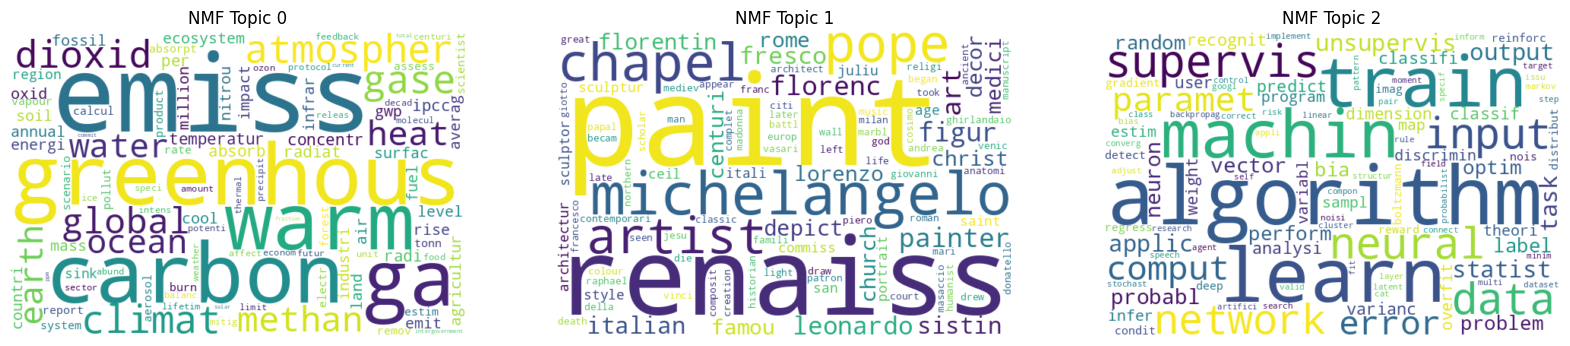


Generating LSA-BoW Topic Word Clouds (Top Positive Words)...


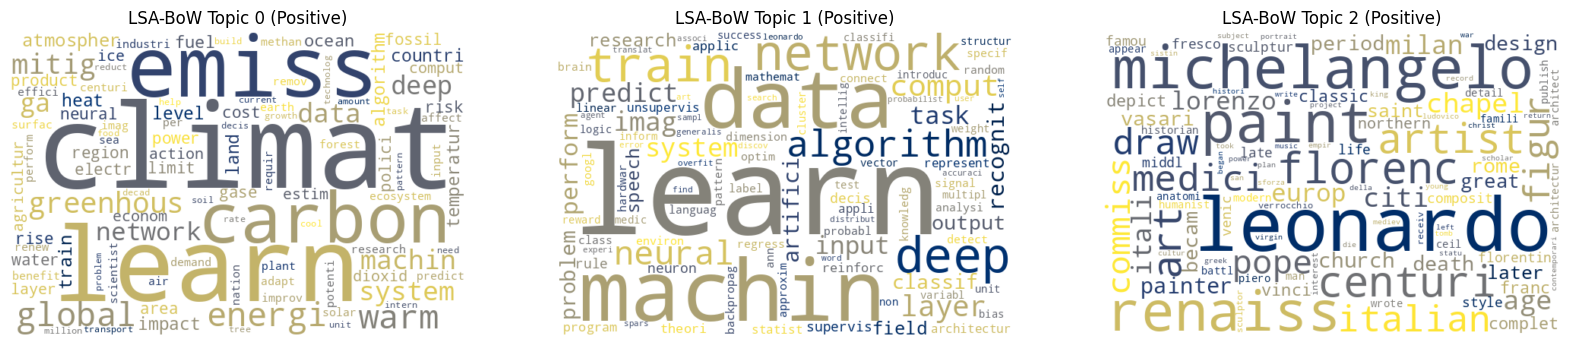


Generating LSA-TFIDF Topic Word Clouds (Top Positive Words)...


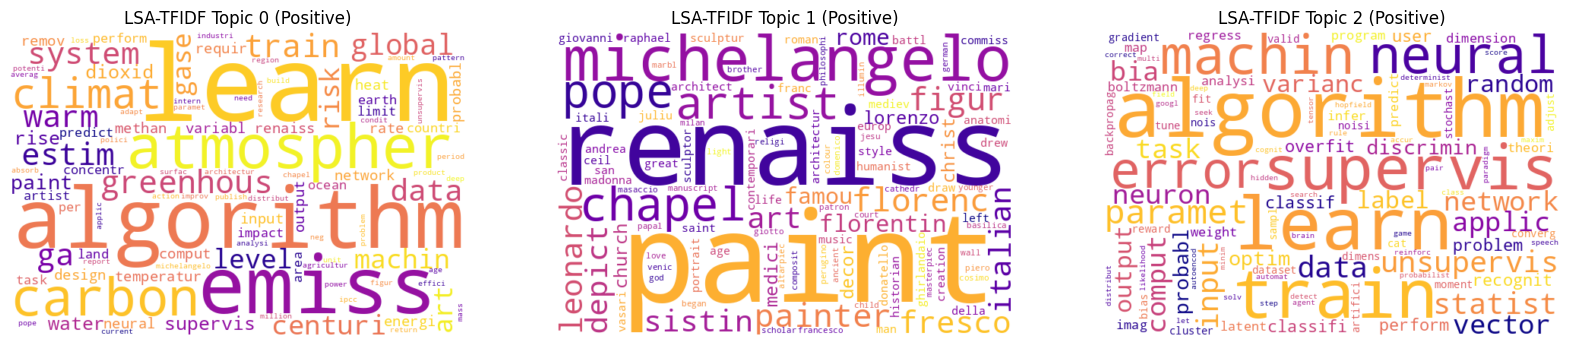

In [14]:
import warnings
warnings.simplefilter(action='ignore', category=DeprecationWarning)
# ===================================================================
# ========== 1. INSTALL LIBRARIES
# ===================================================================
# We install the latest versions to ensure compatibility
!pip install -q --upgrade pyLDAvis
!pip install -q --upgrade wordcloud
!pip install -q numpy  # Ensure numpy is available

import warnings  # <-- NEW: Import the warnings library
# <-- NEW: Add a filter to ignore that specific warning
warnings.filterwarnings("ignore", message="datetime.datetime.utcnow() is deprecated")

import pyLDAvis
import pyLDAvis.gensim_models  # This is still the correct way for Gensim
from wordcloud import WordCloud
import matplotlib.pyplot as plt
from IPython.display import display
import numpy as np

# Enable notebook mode for pyLDAvis
pyLDAvis.enable_notebook()

# ===================================================================
# ========== 2. VISUALIZE GENSIM LDA MODEL (No Change)
# ===================================================================
print("Preparing Gensim LDA visualization...")
vis_gensim = pyLDAvis.gensim_models.prepare(lda_gensim, corpus, dictionary, sort_topics=False)
display(vis_gensim)


# ===================================================================
# ========== 3. VISUALIZE SKLEARN NMF MODEL (No Change)
# ===================================================================
print("\nPreparing Sklearn NMF visualization...")

# 1. Topic-Term distributions (from nmf.components_)
topic_term_dists = nmf.components_ / nmf.components_.sum(axis=1)[:, np.newaxis]

# 2. Document-Topic distributions (from W_nmf)
doc_topic_dists = W_nmf / (W_nmf.sum(axis=1)[:, np.newaxis] + 1e-6)

# 3. Document Lengths (from X_tfidf)
doc_lengths = X_tfidf.sum(axis=1).A1

# 4. Vocab (from tfidf_vec)
vocab = tfidf_vec.get_feature_names_out()

# 5. Term Frequency (from X_tfidf)
term_frequency = X_tfidf.sum(axis=0).A1

# Prepare the data
vis_nmf = pyLDAvis.prepare(
    topic_term_dists=topic_term_dists,
    doc_topic_dists=doc_topic_dists,
    doc_lengths=doc_lengths,
    vocab=vocab,
    term_frequency=term_frequency,
    sort_topics=False
)
display(vis_nmf)


# ===================================================================
# ========== 4. VISUALIZE SKLEARN LSA (BoW) MODEL (NEW!)
# ===================================================================
print("\nPreparing Sklearn LSA (BoW) visualization...")

# HACK: pyLDAvis needs non-negative values. We use np.abs() for LSA.
# This shows topic magnitude but loses the positive/negative distinction.

# 1. Topic-Term distributions
topic_term_dists_lsa_bow = np.abs(svd_bow.components_)
topic_term_dists_lsa_bow = topic_term_dists_lsa_bow / topic_term_dists_lsa_bow.sum(axis=1)[:, np.newaxis]

# 2. Document-Topic distributions
doc_topic_dists_lsa_bow = np.abs(lsa_bow)
doc_topic_dists_lsa_bow = doc_topic_dists_lsa_bow / (doc_topic_dists_lsa_bow.sum(axis=1)[:, np.newaxis] + 1e-6)

# 3. Document Lengths (from X_bow)
doc_lengths_bow = X_bow.sum(axis=1).A1

# 4. Vocab (from bow_vec)
vocab_bow = bow_vec.get_feature_names_out()

# 5. Term Frequency (from X_bow)
term_frequency_bow = X_bow.sum(axis=0).A1

# Prepare the data
vis_lsa_bow = pyLDAvis.prepare(
    topic_term_dists=topic_term_dists_lsa_bow,
    doc_topic_dists=doc_topic_dists_lsa_bow,
    doc_lengths=doc_lengths_bow,
    vocab=vocab_bow,
    term_frequency=term_frequency_bow,
    sort_topics=False
)
display(vis_lsa_bow)


# ===================================================================
# ========== 5. VISUALIZE SKLEARN LSA (TF-IDF) MODEL (NEW!)
# ===================================================================
print("\nPreparing Sklearn LSA (TF-IDF) visualization...")

# HACK: Using np.abs() again for LSA's negative components

# 1. Topic-Term distributions
topic_term_dists_lsa_tfidf = np.abs(svd_tfidf.components_)
topic_term_dists_lsa_tfidf = topic_term_dists_lsa_tfidf / topic_term_dists_lsa_tfidf.sum(axis=1)[:, np.newaxis]

# 2. Document-Topic distributions
doc_topic_dists_lsa_tfidf = np.abs(lsa_tfidf)
doc_topic_dists_lsa_tfidf = doc_topic_dists_lsa_tfidf / (doc_topic_dists_lsa_tfidf.sum(axis=1)[:, np.newaxis] + 1e-6)

# 3, 4, 5: We can re-use the TF-IDF variables from the NMF section
# doc_lengths, vocab, term_frequency

# Prepare the data
vis_lsa_tfidf = pyLDAvis.prepare(
    topic_term_dists=topic_term_dists_lsa_tfidf,
    doc_topic_dists=doc_topic_dists_lsa_tfidf,
    doc_lengths=doc_lengths,  # Re-using from NMF (TF-IDF based)
    vocab=vocab,              # Re-using from NMF (TF-IDF based)
    term_frequency=term_frequency, # Re-using from NMF (TF-IDF based)
    sort_topics=False
)
display(vis_lsa_tfidf)


# ===================================================================
# ========== 6. GENERATE WORD CLOUDS FOR NMF TOPICS (Renumbered)
# ===================================================================
print("\nGenerating NMF Topic Word Clouds...")

H_nmf = nmf.components_
tfidf_terms = tfidf_vec.get_feature_names_out()

fig, axes = plt.subplots(1, 3, figsize=(20, 6))
for topic_idx, topic in enumerate(H_nmf):
    topic_frequencies = {tfidf_terms[i]: topic[i] for i in topic.argsort()[:-100:-1]}
    wc = WordCloud(background_color="white", width=600, height=400, colormap='viridis')
    wc.generate_from_frequencies(topic_frequencies)

    ax = axes[topic_idx]
    ax.imshow(wc, interpolation="bilinear")
    ax.set_title(f"NMF Topic {topic_idx}")
    ax.axis("off")
plt.show()


# ===================================================================
# ========== 7. GENERATE WORD CLOUDS FOR LSA-BoW TOPICS
# ===================================================================
print("\nGenerating LSA-BoW Topic Word Clouds (Top Positive Words)...")

H_lsa_bow = svd_bow.components_
bow_terms = bow_vec.get_feature_names_out()

fig, axes = plt.subplots(1, 3, figsize=(20, 6))
for topic_idx, topic in enumerate(H_lsa_bow):
    # Get top positive words. LSA scores can be negative, so we filter.
    topic_frequencies = {bow_terms[i]: topic[i] for i in topic.argsort()[:-100:-1] if topic[i] > 0}
    if not topic_frequencies:
        topic_frequencies = {"(No positive words)": 1} # Fallback

    wc = WordCloud(background_color="white", width=600, height=400, colormap='cividis')
    wc.generate_from_frequencies(topic_frequencies)

    ax = axes[topic_idx]
    ax.imshow(wc, interpolation="bilinear")
    ax.set_title(f"LSA-BoW Topic {topic_idx} (Positive)")
    ax.axis("off")
plt.show()


# ===================================================================
# ========== 8. GENERATE WORD CLOUDS FOR LSA-TFIDF TOPICS
# ===================================================================
print("\nGenerating LSA-TFIDF Topic Word Clouds (Top Positive Words)...")

H_lsa_tfidf = svd_tfidf.components_
# tfidf_terms already defined in NMF section

fig, axes = plt.subplots(1, 3, figsize=(20, 6))
for topic_idx, topic in enumerate(H_lsa_tfidf):
    # Get top positive words
    topic_frequencies = {tfidf_terms[i]: topic[i] for i in topic.argsort()[:-100:-1] if topic[i] > 0}
    if not topic_frequencies:
        topic_frequencies = {"(No positive words)": 1} # Fallback

    wc = WordCloud(background_color="white", width=600, height=400, colormap='plasma')
    wc.generate_from_frequencies(topic_frequencies)

    ax = axes[topic_idx]
    ax.imshow(wc, interpolation="bilinear")
    ax.set_title(f"LSA-TFIDF Topic {topic_idx} (Positive)")
    ax.axis("off")
plt.show()

## Conclusions

This notebook successfully downloaded, processed, and modeled text from 15 Wikipedia articles covering three distinct subjects: Machine Learning, Climate Change, and Renaissance Art.

The primary goal was to apply and compare four different topic modeling techniques (Initial LDA, LSA on BoW, LSA on TF-IDF, and NMF on TF-IDF) to see how well they could automatically discover these three underlying themes.

### 🎯 Topic Discovery: A Critical Failure and Three Successes

The experiment revealed a stark difference in performance. The corpus was intentionally designed with three subjects whose vocabularies have very little overlap, making it a relatively simple test.

**The Successful Models (LDA, NMF, LSA-TFIDF)**

* **Initial LDA (Gensim):** This model performed perfectly. The Document-topic mixture table (Section 7) shows that every document was assigned with 100% (1.0) probability to its correct topic.
* **NMF (TF-IDF):** This model also achieved a near-perfect separation. The "NMF document-topic proportions" table shows that each document was assigned a very high proportion (e.g., >0.5) to its correct topic and near-zero values for the others.
* **LSA (TF-IDF):** Despite a lower coherence score (see below), this model's top words list shows it successfully identified the three pure topics.

These models all produced clean, distinct, and interpretable topics, as seen in their top-10 word lists:

> * **Topic (Art):** leonardo, michelangelo, renaiss, paint, artist, chapel
> * **Topic (ML):** learn, model,s data, train, algorithm, network
> * **Topic (Climate):** climat, chang, emiss, carbon, warm, greenhous

**The Failed Model (LSA-BoW)**

the **LSA (BoW) model failed** to separate the topics cleanly.

The "LSA-BoW top words" list clearly shows the problem. While it found the Art topic, it conflated Machine Learning and Climate Change:

> * **Topic 0:** climat, learn, emiss, carbon, energi, warm, global... data (This is a mix of Climate and ML)
> * **Topic 1:** learn, machin, data, network, deep (This is a pure ML topic)
> * **Topic 2:** leonardo, michelangelo, paint, renaiss (This is a pure Art topic)

Because Topic 0 is not a coherent theme, the model failed this test.

### 📊 Quantitative Comparison: NMF Wins on Coherence

A quantitative comparison using the **Coherence Score (c_v)**—which measures how semantically related the top words in a topic are—confirms the model differences.

* **NMF (TF-IDF): 0.691 (Highest Score)**
* **Initial LDA (Gensim):** 0.643
* **LSA (BoW):** 0.640
* **Improved LDA (Gensim):** 0.633
* **LSA (TF-IDF): 0.550 (Lowest Score)**

The key takeaway here is that **NMF (TF-IDF)** was the best-performing model both in terms of its clean topic separation and its high coherence score.

It is critical to note that the high score for LSA (BoW) (0.640) is **misleading**. While the words within its mixed topic (like `climat` and `learn`) might co-occur, the topic itself is incoherent and useless for this analysis. This highlights the danger of relying on a single metric.

### 🖼️ Visualization Confirms the Failure

The **pyLDAvis interactive visualizations** provide the final, definitive proof.

* **Successful Plots (LDA, NMF, LSA-TFIDF):** The visualizations for the Initial LDA, NMF, and LSA-TFIDF models all show three large circles (representing the three topics) that are far apart and do not overlap. This is the ideal visual outcome, indicating three highly distinct themes.
* **Failed Plot (LSA-BoW):** In sharp contrast, the pyLDAvis plot for LSA (BoW) visually confirms its failure. Two of the circles (Topic 0 and Topic 1) are shown overlapping significantly. This is the direct visual consequence of Topic 0 being an incoherent mix of Machine Learning and Climate Change terms, causing it to "bleed into" the pure Machine Learning topic.